# Settings

In [1]:
import bluepysnap as snap
import pandas
import numpy
import tqdm
import conntility

from tqdm import notebook as tqdm_notebook

circuit_d = {'v1': "/gpfs/bbp.cscs.ch/project/proj83/jira-tickets/NSETM-2304-extract-hex-O1-042024/data/O1_data/circuit_config.json",
            'v2': "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/InterneuronRewiringO1/circuits/SSCx-HexO1-Release__O1_Schneider_Mizell_v2/circuit_config_reparam_tc.json"}

ntypes_d = {
    "DistTC": [ # MC, BP, DBC
                "L23_MC", "L4_MC", "L5_MC", "L6_MC",
                "L23_BP", "L4_BP", "L5_BP", "L6_BP",
                "L23_DBC", "L4_DBC", "L5_DBC", "L6_DBC"],
    "PeriTC": [ #LBC, NBC
                "L23_LBC", "L4_LBC", "L5_LBC", "L6_LBC",
                "L23_NBC", "L4_NBC", "L5_NBC", "L6_NBC"],
    "SparTC": [ #L1, NGC
                "L1_DAC", "L1_HAC", "L1_LAC", "L1_NGC-DA", "L1_NGC-SA", "L1_SAC",
                "L23_NGC", "L4_NGC", "L5_NGC", "L6_NGC"],
    "InhTC": [#"L23_BP", "L4_BP", "L5_BP", "L6_BP",
                "L23_BTC", "L23_SBC",
                "L4_BTC", "L4_SBC",
                "L5_BTC", "L5_SBC",
                "L6_BTC", "L6_SBC"]
}
ntypes_reverse = {}
[[ntypes_reverse.setdefault(_x, k) for _x in v] for k, v in ntypes_d.items()]
ntypes_rewired = ["SparTC", "PeriTC", "InhTC"]

# n_pre_nrns = 100
# n_post_nrns = -1 # All neurons used when set to -1

n_pre_nrns = 100
n_post_nrns = 10000 # All neurons used when set to -1

base_target = 'hex0'

outdir = 'i_conn_fractions/'
import os; os.makedirs(outdir, exist_ok=True)

In [2]:
def sample_nrn(nrn, i_ana_cls, n=-1):
    samp_nrn = nrn[nrn["i_analysis_class"] == i_ana_cls]

    if n > -1:
        samp_nrn = samp_nrn.sample(n=n)
    return samp_nrn

In [3]:
from conntility.subcellular import MorphologyPathDistanceCalculator
import neurom
import os

# A function to calculate the path distances of all synapses in a dataframe to the soma
def soma_path_distances_factory(morph_root, morph_names, use_section_pos_for=None):
    def soma_path_distances(df_per_post):
        tbl_to_soma = pandas.DataFrame({"afferent_section_id": [0], "afferent_segment_id": [0],
                                   "afferent_segment_offset": [0.0]})
        node_id = df_per_post["@target_node"].values[0]
        morphology = neurom.load_morphology(os.path.join(morph_root, morph_names[node_id] + ".asc"))
        calc = MorphologyPathDistanceCalculator(morphology)
        out = {}
        pd = calc.path_distances(df_per_post, tbl_to_soma)[:, 0]
        # EXPLANATION:
        # ConnectomeManipulator has a known issue: It does not write "afferent_segment_id" nor "afferent_segment_offset".
        # Entries in those columns are all 0.
        # Consequently, the path distances from the soma to the root of the section containing the synapse will 
        # be calculated instead. For these cases, we have to add the offset within the section to the result.
        # "use_section_pos_for" is a Series that specifies for all node_ids whether the presynaptic neuron with that id
        # has been touched by ConnectomeManipulator.
        if use_section_pos_for is not None:
            mask = use_section_pos_for[df_per_post["@source_node"]].values # True if presyn. neuron has been rewired
            sec_lens = numpy.array([1.0] + [_sec.length for _sec in morphology.sections])
            to_add = df_per_post["afferent_section_pos"].values * sec_lens[df_per_post["afferent_section_id"].values]
            pd = pd + (mask.astype(float) * to_add) # Where "False" -> adding zero

        out["soma_path_distance"] = pd
        
        m_sec_types = numpy.array([1] + [int(_sec.type) for _sec in morphology.sections])
        out["afferent_section_type"] = m_sec_types[df_per_post["afferent_section_id"].values]

        out = pandas.DataFrame(out, index=df_per_post.index)
        return out
    return soma_path_distances

In [4]:
def is_clumped(sub_df):
    D = numpy.abs(sub_df.values.reshape((-1, 1)) - sub_df.values.reshape((1, -1)))
    numpy.fill_diagonal(D, numpy.NaN)
    return pandas.DataFrame({"clumped": numpy.any(D < 15.0, axis=0)}, index=sub_df.index)

def add_section_type_info(matrix):
    pw_type = matrix.edge_associated_vertex_properties("mtype")
    matrix.add_edge_property("source_mtype", pw_type["row"].values)
    matrix.add_edge_property("target_mtype", pw_type["col"].values)

    _post_sec_tp = ["is_soma", "is_proximal", "is_apical"]
    pw_type = matrix.edge_associated_vertex_properties("synapse_class")
    matrix.add_edge_property("is_inh", pw_type["col"].values == "INH")
    matrix.add_edge_property("is_soma", (matrix.edges["afferent_section_type"] == 1))
    matrix.add_edge_property("is_proximal", (~matrix.edges["is_soma"] & 
                                             (matrix.edges["soma_path_distance"] <= 50)).values)
    matrix.add_edge_property("is_apical", (~matrix.edges["is_proximal"] & 
                                           (matrix.edges["afferent_section_type"] == 4)).values)
    matrix.add_edge_property("is_distal", ~matrix.edges[_post_sec_tp].any(axis=1).values)

def add_multisyn_info(MM):
    MM.add_edge_property("pre_neuron_idx", MM.edge_associated_vertex_properties("node_ids")["row"].values)
    MM.add_edge_property("post_neuron_idx", MM.edge_associated_vertex_properties("node_ids")["col"].values)

    clumped = MM.edges.groupby(["pre_neuron_idx", "post_neuron_idx", "afferent_section_id"])["soma_path_distance"].apply(is_clumped)
    clumped = clumped.droplevel(["pre_neuron_idx", "post_neuron_idx", "afferent_section_id"]).loc[MM.edges.index]
    MM.add_edge_property("is_clumped", clumped["clumped"].values)

    nsyn = MM.edges[["pre_neuron_idx", "post_neuron_idx"]].value_counts()
    multisyn = (nsyn > 1)
    multisyn = multisyn[MM.edges[["pre_neuron_idx", "post_neuron_idx"]].set_index(["pre_neuron_idx", "post_neuron_idx"]).index]
    MM.add_edge_property("is_multisyn", multisyn.values)

    return nsyn

In [5]:
def build_connectivity_matrix_with_target_info(circ, n_pre_nrns, n_post_nrns, rewired=True):
    # Load neurons
    nrn = conntility.circuit_models.neuron_groups.load_neurons(circ, 
                                                               ["x", "y", "z", "mtype", "etype", "layer", "morphology", "synapse_class"], 
                                                              node_population='S1nonbarrel_neurons',
                                                             base_target=base_target)\
                                                            .reset_index(drop=True)
    nrn["i_analysis_class"] = nrn["mtype"].map(lambda _x: ntypes_reverse.get(_x, "EXC"))
    if rewired:
        been_rewired = nrn["i_analysis_class"].map(lambda _x: _x in ntypes_rewired)
        been_rewired.index = nrn["node_ids"]
    else:
        been_rewired = None
    edges = circ.edges['S1nonbarrel_neurons__S1nonbarrel_neurons__chemical']
    nodes = circ.nodes['S1nonbarrel_neurons']

    post_nrn = nrn.loc[numpy.random.choice(nrn.index, n_post_nrns, replace=False)]
    pre_nrn = pandas.concat([
        sample_nrn(nrn, _cls, n=n_pre_nrns)
        for _cls in list(ntypes_d.keys())
    ], axis=0).sort_values("node_ids").reset_index(drop=True)
    # Load synapses
    E = edges.pathway_edges(source=pre_nrn["node_ids"], target=post_nrn["node_ids"],
                           properties=['@source_node', '@target_node', 'afferent_section_id',
                                      'afferent_segment_id', 'afferent_segment_offset',
                                       'conductance', 'afferent_section_pos', # 'afferent_section_type'
                                      'afferent_center_x', 'afferent_center_y', 'afferent_center_z'])
    # Add soma path distance info
    morph_names = nodes.get(E["@target_node"].drop_duplicates(), properties="morphology")
    morph_root = nodes.config["alternate_morphologies"]["neurolucida-asc"]
    tqdm_notebook.tqdm.pandas()
    soma_pd = E.groupby("@target_node").progress_apply(soma_path_distances_factory(morph_root, morph_names,
                                                                                   use_section_pos_for=been_rewired))
    E = pandas.concat([E, soma_pd.droplevel("@target_node")], axis=1)
    # Build ConnectivityMatrix object
    idx_mapper = nrn.reset_index().set_index("node_ids")["index"]

    E_ids = pandas.concat([
        idx_mapper[E["@source_node"]].reset_index(drop=True),
        idx_mapper[E["@target_node"]].reset_index(drop=True)
    ], axis=1, keys=["row", "col"])

    M = conntility.ConnectivityMatrix(
        E_ids,
        edge_properties=E.drop(["@source_node", "@target_node"], axis="columns").reset_index(drop=True),
        vertex_properties=nrn,
        shape=(len(nrn), len(nrn))
    ).default("conductance")

    add_section_type_info(M)
    _ = add_multisyn_info(M)
    return M


# Calculate fraction statistics and persist

In [6]:
rewired = dict({"v1": False, "v2": True})
cols_to_plot = ["is_inh", "is_soma", "is_proximal", "is_apical", "is_distal", "is_clumped", "is_multisyn"]
i_ana_classes = list(ntypes_d.keys())

list_of_results = []
list_of_circ_names = []
for circ_name, circ_path in circuit_d.items():
    circ = snap.Circuit(circ_path)
    M = build_connectivity_matrix_with_target_info(circ, n_pre_nrns, n_post_nrns,
                                                   rewired=rewired[circ_name])
    res = pandas.concat([
        M.filter("i_analysis_class", side="row").eq(_cls).edges[cols_to_plot].mean(axis=0)
        for _cls in i_ana_classes
    ], axis=1, keys=i_ana_classes, names=["i_analysis_class"])
    
    list_of_results.append(res)
    list_of_circ_names.append(circ_name)
    
result_df = pandas.concat(list_of_results, axis=1, keys=list_of_circ_names, names=["Circuit"])

  0%|          | 0/7818 [00:00<?, ?it/s]

  0%|          | 0/9881 [00:00<?, ?it/s]

In [7]:
display(result_df)

result_df.to_hdf("i_conn_fractions/circuits_data.h5", "data")

Circuit                 v1                                      v2            \
i_analysis_class    DistTC    PeriTC    SparTC     InhTC    DistTC    PeriTC   
is_inh            0.052594  0.055686  0.053154  0.056384  0.058671  0.090383   
is_soma           0.062928  0.059620  0.032753  0.068459  0.057156  0.243249   
is_proximal       0.129699  0.136521  0.089781  0.139571  0.128470  0.614659   
is_apical         0.486798  0.420012  0.690848  0.423978  0.492065  0.074868   
is_distal         0.320575  0.383847  0.186618  0.367992  0.322308  0.067223   
is_clumped        0.527521  0.511955  0.545274  0.542835  0.523690  0.288421   
is_multisyn       0.999345  0.999750  0.996669  0.997670  0.999316  0.685804   

Circuit                               
i_analysis_class    SparTC     InhTC  
is_inh            0.058237  0.673669  
is_soma           0.022663  0.066375  
is_proximal       0.067069  0.136422  
is_apical         0.720786  0.155722  
is_distal         0.189482  0.641481  
is_clumped        0.071171  0.246085  
is_multisyn       0.458430  0.636970

/nvme/isbister/2149804/ipykernel_8640/1782476270.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  result_df.to_hdf("i_conn_fractions/circuits_data.h5", "data")


# Load computed dataframes for v1, v2, MICrONS

In [1]:
import pandas as pd
circ_fractions = pd.read_hdf("i_conn_fractions/circuits_data.h5", "data")
microns_df = pd.read_hdf("i_conn_fractions/inh_targeting_data.h5", key="data").transpose().reset_index().drop('level_1', axis=1)\
                .rename(columns={"level_0":'i_analysis_class'})
microns_fractions = microns_df.groupby('i_analysis_class').mean().transpose()
microns_fractions = microns_fractions[circ_fractions["v1"].columns].loc[circ_fractions.index] # Force same ordering

In [9]:
circ_fractions

Circuit                 v1                                      v2            \
i_analysis_class    DistTC    PeriTC    SparTC     InhTC    DistTC    PeriTC   
is_inh            0.052594  0.055686  0.053154  0.056384  0.058671  0.090383   
is_soma           0.062928  0.059620  0.032753  0.068459  0.057156  0.243249   
is_proximal       0.129699  0.136521  0.089781  0.139571  0.128470  0.614659   
is_apical         0.486798  0.420012  0.690848  0.423978  0.492065  0.074868   
is_distal         0.320575  0.383847  0.186618  0.367992  0.322308  0.067223   
is_clumped        0.527521  0.511955  0.545274  0.542835  0.523690  0.288421   
is_multisyn       0.999345  0.999750  0.996669  0.997670  0.999316  0.685804   

Circuit                               
i_analysis_class    SparTC     InhTC  
is_inh            0.058237  0.673669  
is_soma           0.022663  0.066375  
is_proximal       0.067069  0.136422  
is_apical         0.720786  0.155722  
is_distal         0.189482  0.641481  
is_clumped        0.071171  0.246085  
is_multisyn       0.458430  0.636970

In [10]:
microns_fractions

i_analysis_class,DistTC,PeriTC,SparTC,InhTC
is_inh,0.084549,0.072762,0.172920,0.849007
is_soma,0.008698,0.176768,0.043771,0.046499
is_proximal,0.211747,0.669577,0.158490,0.190003
is_apical,0.400393,0.054785,0.642136,0.352839
is_distal,0.342031,0.054357,0.150794,0.331766
is_clumped,0.339226,0.519175,0.268639,0.476663
is_multisyn,0.741021,0.832049,0.276335,0.694532


# Create heatmaps

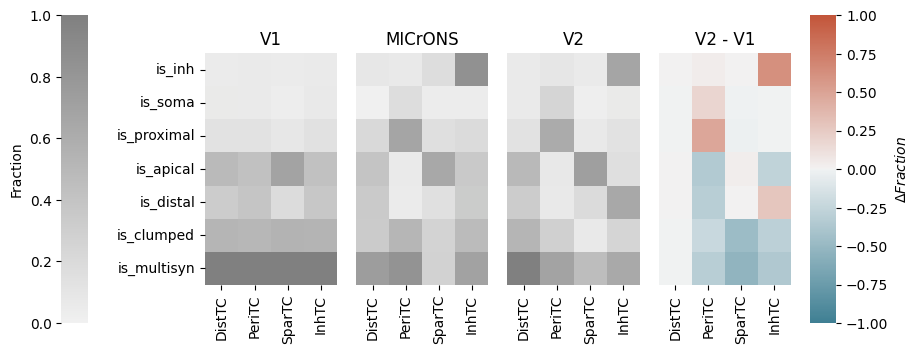

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
v1_fractions = circ_fractions["v1"]; v2_fractions = circ_fractions["v2"]

cmap = sns.light_palette("grey", as_cmap=True)
# diff_cmap = sns.color_palette("vlag", as_cmap=True)
# diff_cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
# diff_cmap = sns.color_palette("bwr", as_cmap=True)
diff_cmap = sns.diverging_palette(220, 20, as_cmap=True)

def i_conn_heatmap(data, ax, title='', vmin=0.0, vmax=1.0, cmap='', cbar_title='', yticklabels='auto', cbar_ax=None, cbar_ticks_side='right'):
    
    xticklabels = 'auto'
    
    cbar = False
    if cbar_ax != None:
        cbar = True
        

    sns.heatmap(data, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, xticklabels=xticklabels, yticklabels=yticklabels, cbar=cbar, cbar_kws={'label': cbar_title}, cbar_ax=cbar_ax, square=True) # vmin=vmin, vmax=vmax,
    
    if cbar_ax != None:
        cbar_ax.yaxis.set_ticks_position(cbar_ticks_side)
        cbar_ax.yaxis.set_label_position(cbar_ticks_side)
    
    ax.set_ylabel('') 
    ax.set_xlabel('')
    ax.set_title(title)


import matplotlib
from matplotlib.gridspec import GridSpec
# figsize = (8,2)
# fig, axes = plt.subplots(1, 4, figsize=figsize)
gs = GridSpec(1, 7, width_ratios=[.6, 1.8, 3, 3, 3, 3, .6])
fig = plt.figure(figsize=(10, 4))

# Create subplots for heatmaps and colorbars
ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax1.set_visible(False)
ax2 = plt.subplot(gs[0, 2])
ax3 = plt.subplot(gs[0, 3])
ax4 = plt.subplot(gs[0, 4])
ax5 = plt.subplot(gs[0, 5])
ax6 = plt.subplot(gs[0, 6])

i_conn_heatmap(v1_fractions, ax2, title='V1', vmin=0.0, vmax=1.0, cmap=cmap, cbar_title="Fraction", cbar_ax=ax0, cbar_ticks_side='left')
i_conn_heatmap(microns_fractions, ax3, title='MICrONS', vmin=0.0, vmax=1.0, cmap=cmap, yticklabels=False)
i_conn_heatmap(v2_fractions, ax4, title='V2', vmin=0.0, vmax=1.0, cmap=cmap, yticklabels=False)
i_conn_heatmap(v2_fractions - v1_fractions, ax5, title='V2 - V1', vmin=-1.0, vmax=1.0, cmap=diff_cmap, cbar_title="$\Delta  Fraction$", yticklabels=False, cbar_ax=ax6)

# plt.tight_layout()
plt.savefig("i_conn_fractions/iconn_fractions.pdf")
plt.show()
plt.close()






In [ ]:


# def i_conn_heatmap(data, axes, r_ind, c_ind, title='', vmin=0.0, vmax=1.0, cmap='', cbar_title=''):
    
#     ax = axes[r_ind][c_ind]
#     n_rows = len(axes); n_cols = len(axes[0])
    
#     xticklabels = 'auto'
#     yticklabels = 'auto'
#     cbar = True
#     if r_ind == 0: xticklabels = False
#     if c_ind > 0: yticklabels = False
#     if c_ind < n_cols - 1: cbar = False
        
#     from matplotlib.colors import LogNorm, Normalize, SymLogNorm

#     sns.heatmap(data, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, xticklabels=xticklabels, yticklabels=yticklabels, cbar=cbar, cbar_kws={'label': cbar_title}) # vmin=vmin, vmax=vmax,
#     ax.set_ylabel('') 
#     ax.set_xlabel('')
#     ax.set_title(title)


# figsize = (4,4)
# fig, axes = plt.subplots(2, 4, figsize=figsize)
# # 1st row
# i_conn_heatmap(v1_fractions, axes, 0, 0, title='V1', vmin=0.0, vmax=1.0, cmap=cmap)
# i_conn_heatmap(v2_fractions - v1_fractions, axes, 0, 1, title='V2 - V1', vmin=-1.0, vmax=1.0, cmap=diff_cmap, cbar_title="$\Delta_{Fraction}$")
# # 2nd row
# i_conn_heatmap(microns_fractions, axes, 1, 0, title='MICrONS', vmin=0.0, vmax=1.0, cmap=cmap, cbar_title="Fraction")
# i_conn_heatmap(v2_fractions, axes, 1, 1, title='V2', vmin=0.0, vmax=1.0, cmap=cmap)
# plt.tight_layout()
# plt.savefig("i_conn_fractions/iconn_fractions.pdf")
# plt.show()
# plt.close()




# axes = axes.reshape(1, 4)
# 1st row
# i_conn_heatmap(v1_fractions, axes, 0, 0, title='V1', vmin=0.0, vmax=1.0, cmap=cmap)
# i_conn_heatmap(microns_fractions, axes, 0, 1, title='MICrONS', vmin=0.0, vmax=1.0, cmap=cmap, cbar_title="Fraction")
# i_conn_heatmap(v2_fractions, axes, 0, 2, title='V2', vmin=0.0, vmax=1.0, cmap=cmap)
# i_conn_heatmap(v2_fractions - v1_fractions, axes, 0, 3, title='V2 - V1', vmin=-1.0, vmax=1.0, cmap=diff_cmap, cbar_title="$\Delta_{Fraction}$")
# plt.tight_layout()
# plt.savefig("i_conn_fractions/iconn_fractions.pdf")
# plt.show()
# plt.close()




    
# figsize = (9,3)
# fig, axes = plt.subplots(3, 4, figsize=figsize)

# cmap = sns.light_palette("seagreen", as_cmap=True)
# diff_cmap = sns.color_palette("vlag", as_cmap=True)
# diff_cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
# diff_cmap = sns.color_palette("bwr", as_cmap=True)

# v1_fractions = circ_fractions["v1"]; v2_fractions = circ_fractions["v2"]

# i_conn_heatmap(v1_fractions, axes, 0, 0, title='V1', vmin=0.0, vmax=1.0, cmap=cmap)
# i_conn_heatmap(v2_fractions, axes, 0, 1, title='V2', vmin=0.0, vmax=1.0, cmap=cmap)
# i_conn_heatmap(microns_fractions, axes, 0, 2, title='MICrONS', vmin=0.0, vmax=1.0, cmap=cmap, cbar_title="Fraction")


# i_conn_heatmap(v1_fractions - microns_fractions, axes, 1, 0, title='V1 - MICrONS', vmin=-1.0, vmax=1.0, cmap=diff_cmap)
# i_conn_heatmap(v2_fractions - microns_fractions, axes, 1, 1, title='V2 - MICrONS', vmin=-1.0, vmax=1.0, cmap=diff_cmap)
# i_conn_heatmap(v2_fractions - v1_fractions, axes, 1, 2, title='V2 - V1', vmin=-1.0, vmax=1.0, cmap=diff_cmap, cbar_title="$\Delta_{Fraction}$")

# i_conn_heatmap((v1_fractions - microns_fractions) / microns_fractions, axes, 2, 0, title='V1 / MICrONS', vmin=-1.0, vmax=1.0, cmap=diff_cmap)
# i_conn_heatmap((v2_fractions - microns_fractions) / microns_fractions, axes, 2, 1, title='V2 / MICrONS', vmin=-1.0, vmax=1.0, cmap=diff_cmap)
# i_conn_heatmap(v2_fractions / v1_fractions, axes, 2, 2, title='V2 / V1', vmin=0.0, vmax=2.0, cmap=diff_cmap, cbar_title="$\Delta_{Fraction}$")

# plt.tight_layout()
# plt.savefig("i_conn_fractions/iconn_fractions.pdf")
# plt.show()


# print((v1_fractions - microns_fractions) / microns_fractions)
# print((v2_fractions - microns_fractions) / microns_fractions)

# print(v1_fractions)
# print(v2_fractions)
# print(microns_fractions)
# print(v2_fractions - microns_fractions)



In [12]:
# !pip freeze
# !pip install -U Connectome-Utilities